In [5]:
from JupyterImport import *
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
root_logger.setLevel(logging.WARNING)
import copy
from src.Scripts.SquareWaveAnalysis import avg_transition_sw

In [170]:
[DatHandler.remove_dat(dat.datnum, 'base') for dat in dats]

[None, None]

In [12]:

dats = get_dats((6780, 6885+1))  # 100mK Along transition in 3x DAC steps
dats.extend(get_dats((6887, 6894+1)))  # Computer crashed, so carrying on from here

dats.extend(get_dats((7056, 7147+1)))  # WIth ramp square wave
dats.extend(get_dats((7149, 7186+1)))  # Finishing first set after crash

dats.extend(get_dats((7208, 7307+1)))  # Second set

# dats = get_dats((7313, 7315+1), overwrite=False)
# dats.extend(get_dats([6796]))

# dats = get_dats((7316, 7384+1))  # three repeats of weakly coupled only, 1 part, 500 wide (each side) 12.5Hz... trying to reduce error bars

# dats = get_dats((7393, 7395+1), overwrite=False)
# dats.extend(get_dats((7400, 7404+1), overwrite=False))

# dats = get_dats((7397, 7398+1))  # Using Lock in for CS

# dats = get_dats((7406, 7408+1))  # 100mT at -390mV LCT only

# dats = get_dats((7409, 7410))  # 110mK -50mT for NRG calibration

# dats = get_dats((7410, 7451+1))  # 100mT, -50mK along weakly coupled transition

# dats = get_dats((7468, 7470+1), overwrite=False)  # EXTREMETLY slow sweeping (1.3mV/s LP*200) trying to match Mar19 data

paired = False
for dat in dats:
    Fixes.fix_magy(dat)
    
dat_dict = {dat.datnum: dat for dat in dats}

if paired is True:
    p1_dats = dats[::2]
    dat_pairs = [(dat, dat_dict[dat.datnum+1]) for dat in p1_dats]
else:
    p1_dats = 'Not paired'
    dat_pairs = 'Not paired'

100% (106 of 106) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (92 of 92) |########################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (38 of 38) |########################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24


## Set up default fitting parameters, and use this to fit all/weakly coupled data

In [135]:
filt_name = 'LCT'
filt_threshold = -375
filt_val = lambda pair: pair[0].Logs.fds['LCT']
filt_func = lambda pair: filt_val(pair) > filt_threshold  # Returns True if dat pair is gamma broadened (or starting to be gamma broadened)

In [180]:
analysis_params = EA.EA_params(bin_data=False, num_per_row=500,
                               sub_const=True, sub_const_range=(-350, -250),
                               sub_line=False, sub_line_range=(-4000, -600),
                               int_entropy_range=(250, 350),
                               allowed_amp_range=(0.1,1.601), default_amp=0.954,
                               allowed_dT_range=(0.001, 20.002), default_dT=2.71,
                               CT_fit_range=(-500, 500), CT_fit_func='i_sense', CT_fit_param_edit_kwargs={},
                               fit_param_edit_kwargs=dict(),
                               E_fit_range=(-500, 500), 
                               calculate_uncertainty=True, 
                               batch_uncertainty=1,
                               center_data=True)

In [136]:
recalculate = False

if paired is True:
    for pair in progressbar(dat_pairs):
        if (recalculate or not hasattr(pair[0].Other, 'EA_values')) and not filt_func(pair):
            EA.standard_square_process(pair, analysis_params)
else:
    for dat in progressbar(dats):
        if (recalculate or not hasattr(dat.Other, 'EA_values')) and not filt_func([dat]):
            EA.standard_square_process(dat, analysis_params)

N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

KeyError: 'LCT'

## Fit Dats that are Gamma broadened using some fixed values determined from weakly coupled

Filter the dats to get only dats that are gamma broadened (or whatever the filter is)

Set up some new fixed parameters

In [50]:
gamma_analysis_params = copy.copy(analysis_params)
gamma_analysis_params.sub_const=True
# gamma_analysis_params.sub_const_range=(-350, -250) # Set per data based on gamma value (might require processing twice)
# gamma_analysis_params.int_entropy_range = (350, 450) # Set per data "" "" 

gamma_analysis_params.allowed_amp_range = (0,0.01)
# gamma_analysis_params.default_amp = 0.949
gamma_analysis_params.allowed_dT_range = (1,1.01)
# gamma_analysis_params.default_dT = 2.470

gamma_analysis_params.CT_fit_func = 'i_sense_digamma'
gamma_analysis_params.CT_fit_param_edit_kwargs = {'param_name': ['theta'], 'value': [21.064], 'vary': [False]}

In [53]:
recalculate = False
for pair in progressbar(dat_pairs):
    if (recalculate or not hasattr(pair[0].Other, 'EA_values')) and filt_func(pair):
        if (vs:= getattr(pair[0].Other, 'EA_values', None)) is not None and not np.isnan(vs.g):
            w = 250+3*vs.g
        else:
            gamma_analysis_params.calculate_uncertainty = False  # Speed up prelim calcs
            EA.standard_square_process(pair, gamma_analysis_params)  # Run once just for the i_sense_digamma fit
            gamma_analysis_params.calculate_uncertainty = True
            g = pair[0].Other.EA_values.g  # This should now exist having run processing already
            w = 250+3*g
        gamma_analysis_params.sub_const_range = (-100-w, -w)
        gamma_analysis_params.int_entropy_range = (w, w+100)
        
        EA.standard_square_process(pair, gamma_analysis_params)


100% (85 of 85) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


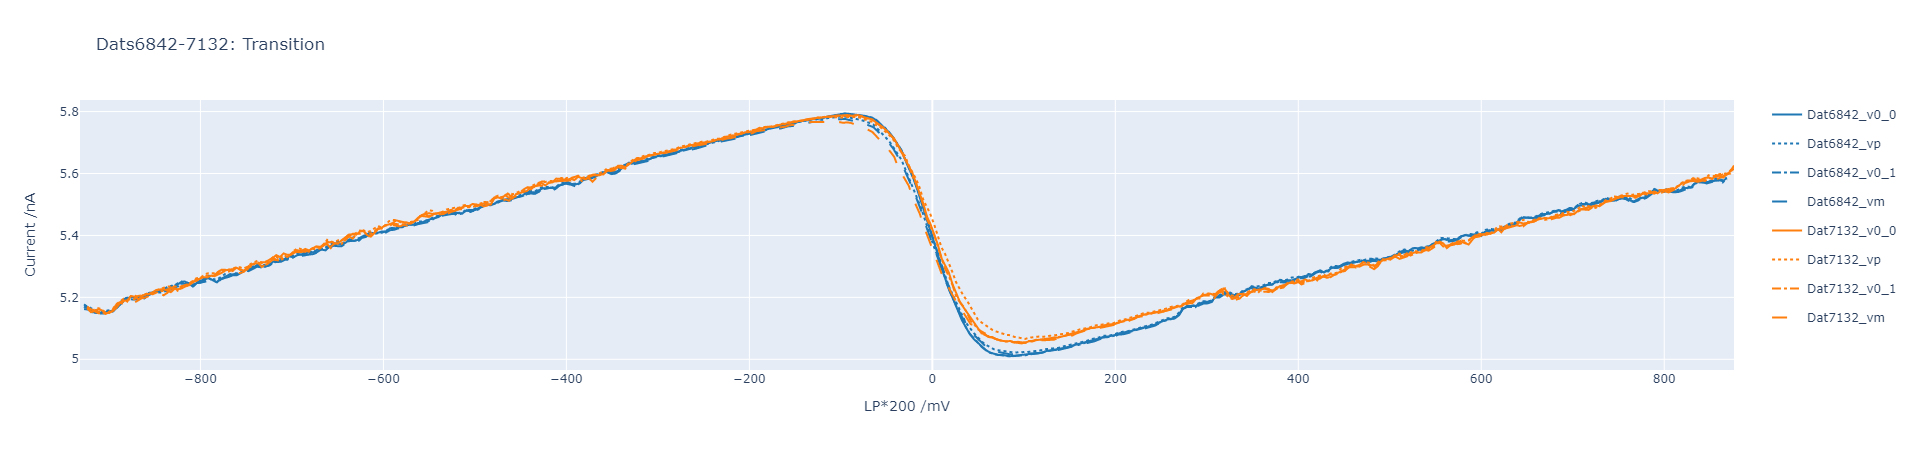

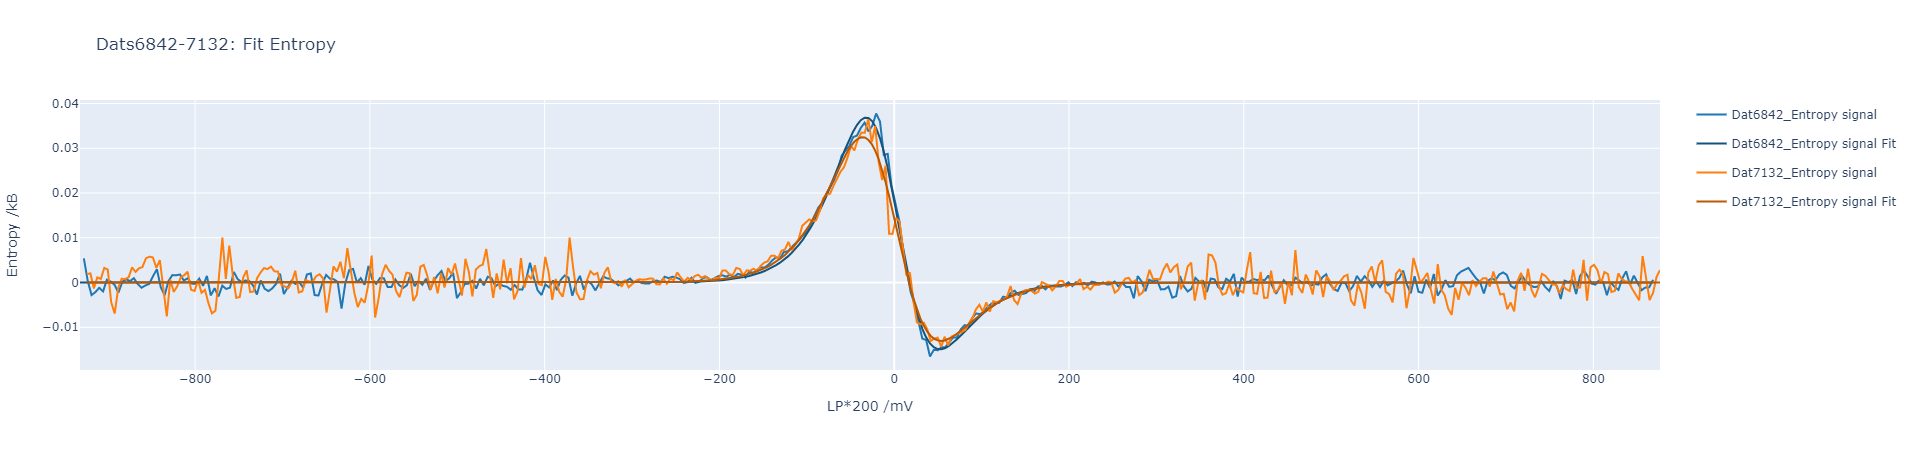

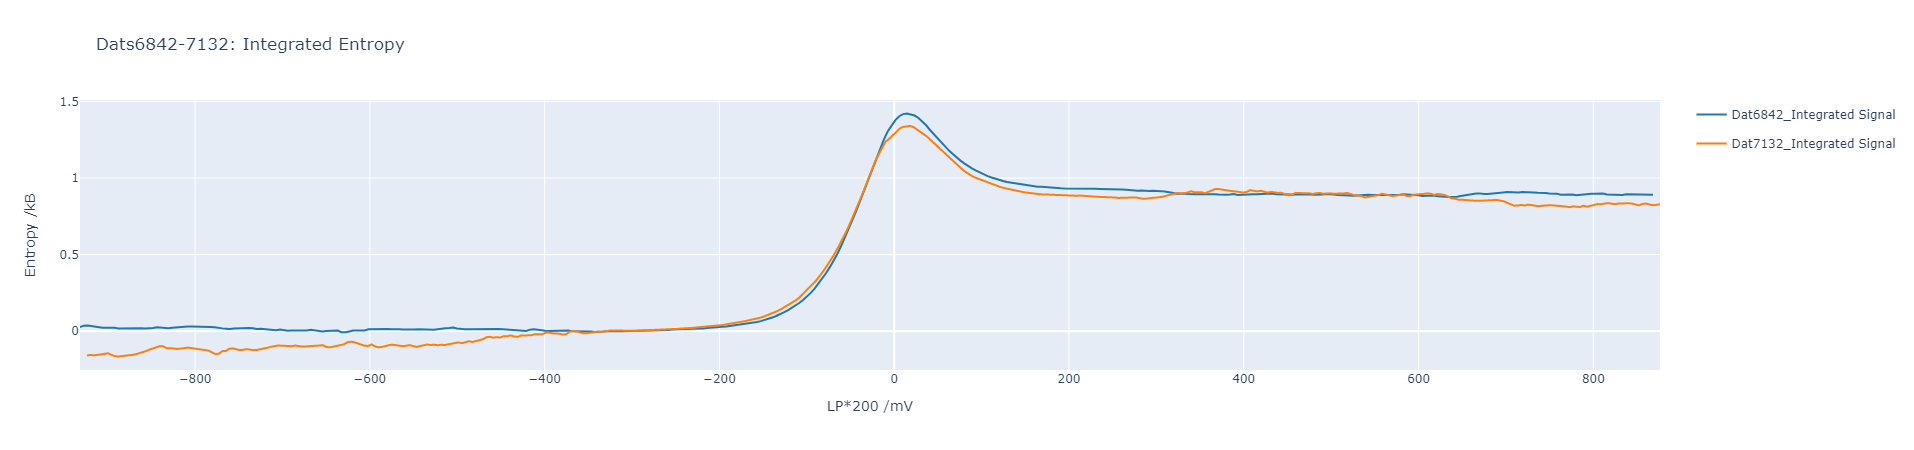

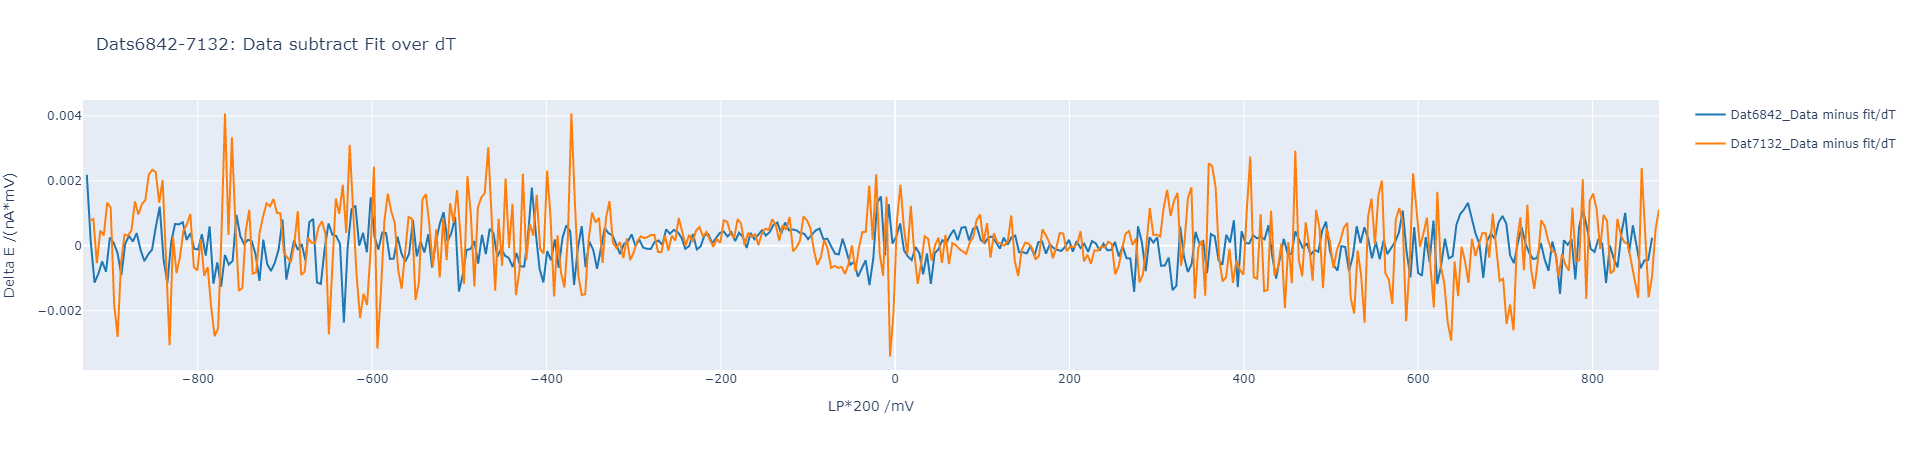

In [190]:
lims = (None, None)
dd = {dat.datnum: dat for dat in dats}
# start = 4893  #4881
start = 6146
single_dat = False
# ds = [dd[num] for num in [start, start+44, start+44*2]]  # 
a = 0
# ds = [dd[num] for num in [6219+a, 6275+a, 6331+a, 6517+a, 6182+a]]
# ds = [dd[num] for num in [7142, 7138, 7167, 7098, 7106, 7144, 7136, 7155, 7222, 7185]]
# ds = [dd[num] for num in [7163, 7128, 7124, 7185]]
# ds = [dd[num] for num in [7338, 7338+23, 7338+23*2]]
# ds = [dd[num] for num in [7078, 7157, 7173, 7185]]  # 4 points that I'm getting better data for Josh talk for
ds = [dd[num] for num in [6842, 7132]]
# ds = [dd[num] for num in np.arange(start, start+10, 2)]
# ds = dats
# ds = [dat for dat in dats if 0.85 < dat.Other.EA_values.int_dS < 0.95]
# ds = [dd[num] for num in np.arange(start, start+37, 4)]  # RCB
# ds = [dd[num] for num in np.arange(start, start+281, 40)]  # field
# ds = [dd[num] for num in np.arange(start, start+41, 8)]  # hqpc

get_additional_data = [lambda dat: dat.Logs.fds['LCT'],
                       lambda dat: dat.AWG.AWs[0][0][1]/10,
                       lambda dat: dat.Other.EA_values.dT,
                       lambda dat: dat.Other.EA_values.dS,
                       lambda dat: dat.Other.EA_values.int_dS,
                       lambda dat: dat.Logs.fds['LCSS'],
                       lambda dat: dat.Logs.fds['LCB'],
                       lambda dat: dat.AWG.info.measureFreq/dat.AWG.info.wave_len,
                       lambda dat: dat.Logs.fds['LP*2']]
additional_hover_template = '<br>'.join(('<extra>%{fullData.name}', 
                                         'LCT=%{customdata[1]:.1f}mV',
                                         'Bias=%{customdata[2]:.0f}nA',
                                         'dT=%{customdata[3]:.2f}mV',
                                         'dS=%{customdata[4]:.2f}kB',
                                         'int_dS=%{customdata[5]:.2f}kB',
                                         'LCSS=%{customdata[6]:.1f}mV',
                                         'LCB=%{customdata[7]:.1f}mV',
                                         'Freq=%{customdata[8]:.1f}Hz', 
                                         'LP*2=%{customdata[9]:.1f}mV'
                                         '</extra>'))

figt = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='transition', mode='lines', add_fits=False, shift_per=0.0, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
fige = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='entropy', mode='lines', add_fits=True, shift_per=0.00, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
figi = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='integrated', mode='lines', add_fits=False, shift_per=0.0, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
figdmf = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='data_minus_fit_scaled', mode='lines', add_fits=False, shift_per=0.00, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
figs = (figt, fige, figi, figdmf)
# figs = [figi]
for fig in figs:
    title = fig.layout.title.text
    field = ds[0].Logs.magy.field
    bias = ds[0].AWG.AWs[0][0][1]/10
#     fig.update_layout(title=title+f'<br>Field={field:.0f}mT, HQPC Bias={bias:.1f}nA')

for fig in figs:
    fig.show()

In [20]:
names = ('Transition', 'Entropy', 'Integrated Entropy', 'Data minus fit over dT')
save_graph=True
graphs_to_save = [2]
if save_graph:
    for i in graphs_to_save:
        figs[i].write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum} -- Waterfall plot of {names[i]}.html')

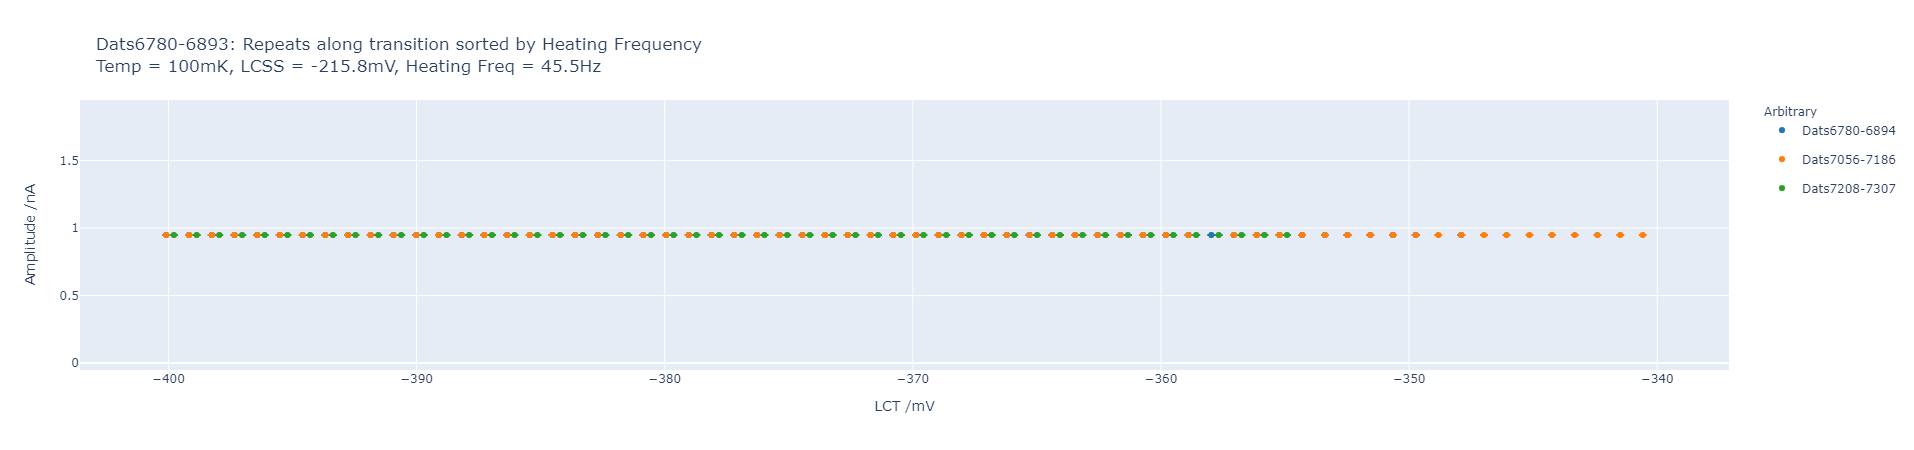

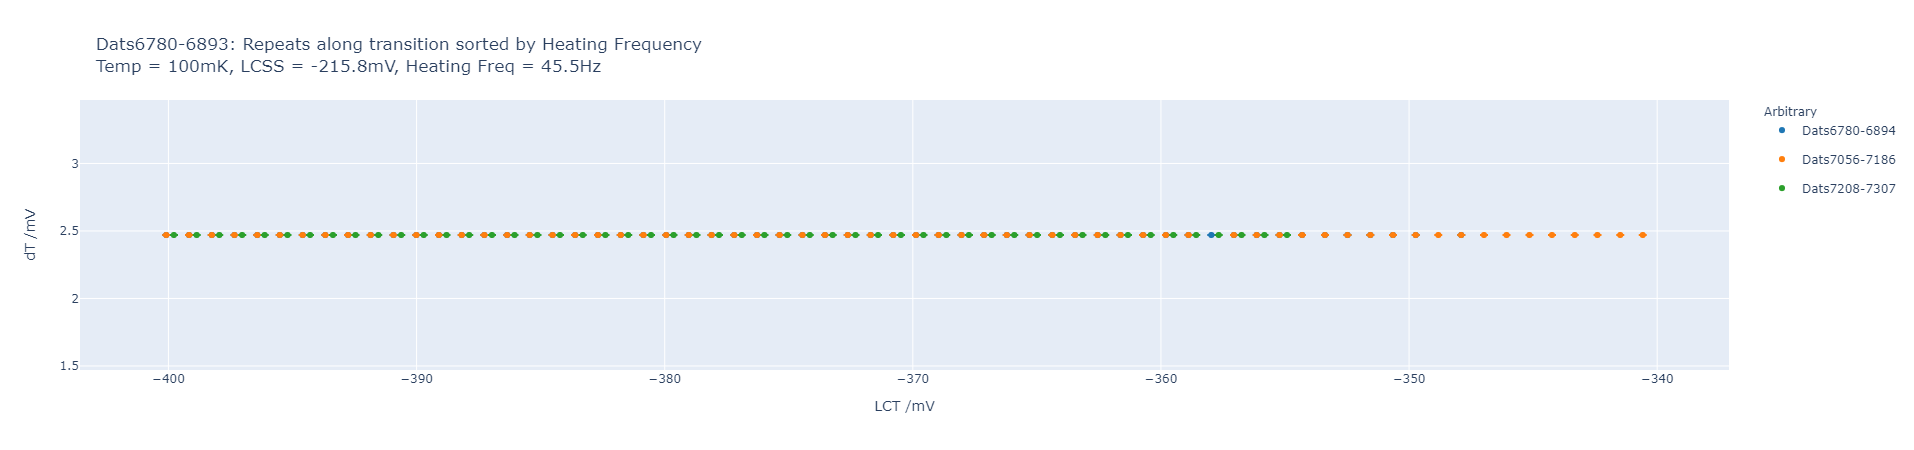

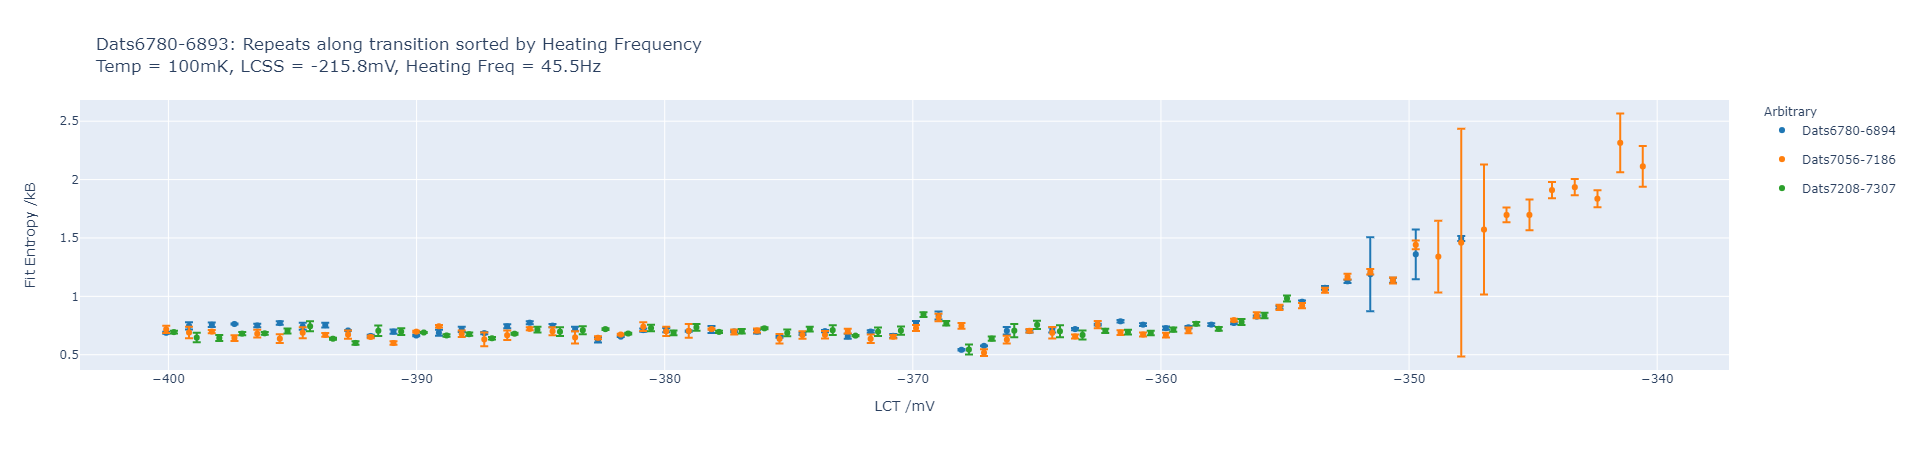

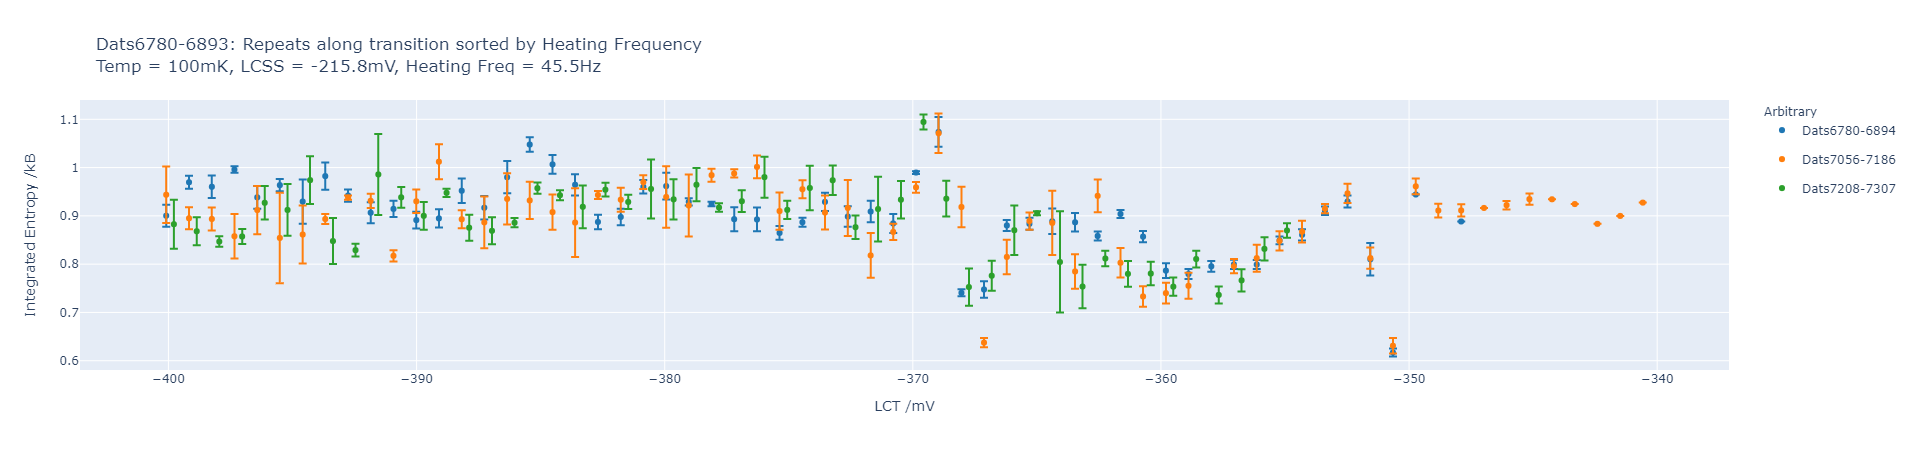

In [14]:
which_sorts = ['freq']*4
tols = [1]*4
which_ys = ['amp', 'dt', 'fit_ds', 'int_ds']
# which_xs = ['field']*4
which_xs = ['lct']*4

# which_sorts = ['field']*4
# tols = [10]*4
# which_ys = ['amp', 'dt', 'fit_ds', 'int_ds']
# which_xs = ['field']*4

dat_sets = [[d for d in dats if d.datnum < 6895], [d for d in dats if  6895 < d.datnum < 7187], [d for d in dats if d.datnum > 7187]]   # Split into separate parts, might not be in order
# dat_sets = [[d for d in dats if d.datnum < 7339], [d for d in dats if  7339 <= d.datnum <= 7361], [d for d in dats if d.datnum > 7361]]   # Split into separate parts, might not be in order
# dat_sets = [[d for d in dats if d.datnum <= 7430], [d for d in dats if  7431 <= d.datnum <= 7451]]   # Split into separate parts, might not be in order
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order
# dat_sets = [dats]

get_additional_data = [lambda dat: dat.Logs.bds['RCB'],
                       lambda dat: dat.SquareEntropy.SquareAWG.AWs[0][0][1]/10,
                       lambda dat: dat.Other.EA_values.dT,
                       lambda dat: dat.Other.EA_values.amp,
                       lambda dat: dat.Other.EA_values.dS,
                       lambda dat: dat.Other.EA_values.int_dS,
                       lambda dat: dat.Logs.magy.field, 
                       lambda dat: dat.Other.EA_values.g]
additional_hover_template = '<br>'.join(('<extra>%{fullData.name}', 
                                         'RCB=%{customdata[1]:.1f}mV',
                                         'Bias=%{customdata[2]:.0f}nA',
                                         'dT=%{customdata[3]:.2f}mV',
                                         'amp=%{customdata[4]:.2f}nA',
                                         'dS=%{customdata[5]:.2f}kB',
                                         'int_dS=%{customdata[6]:.2f}kB',
                                         'Field=%{customdata[7]:.0f}mT', 
                                         'Gamma=%{customdata[8]:.1f}mV'
                                         '</extra>'))
figs = list()
for which_sort, which_y, which_x, tol in zip(which_sorts, which_ys, which_xs, tols):
    figs.append(EA.Plots.sorted(dat_sets[0], which_sort=which_sort, which_x=which_x, which_y=which_y, sort_tol=tol, uncertainties='bars', get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, legend_label=f'Dats{dat_sets[0][0].datnum}-{dat_sets[0][-1].datnum}'))
    if len(dat_sets) > 1:
        for ds in dat_sets[1:]:
            EA.Plots.sorted(ds, fig=figs[-1], which_sort=which_sort, which_x=which_x, which_y=which_y, sort_tol=tol, uncertainties='bars', get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, legend_label=f'Dats{ds[0].datnum}-{ds[-1].datnum}')
for fig, ws in zip(figs, which_sorts):
    if len(dat_sets) > 1:
        fig.update_layout(legend_title='Arbitrary')
    else:
        fig.update_layout(legend_title = ws.upper())
    
    fig.update_layout(title = fig.layout.title.text+f'<br>Temp = {dats[0].Logs.temps.mc*1000:.0f}mK, LCSS = {dats[0].Logs.fds["LCSS"]:.1f}mV, Heating Freq = {dats[0].AWG.freq:.1f}Hz')
for fig in figs:
    fig.show()

In [27]:
save_graph=True
graphs_to_save = [0,1,2,3]
if save_graph:
    for i in graphs_to_save:
        figs[i].write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum} -- Repeats along transition various {which_sorts[i]} -- {which_ys[i]} vs {which_xs[i]}.html')

(50,)

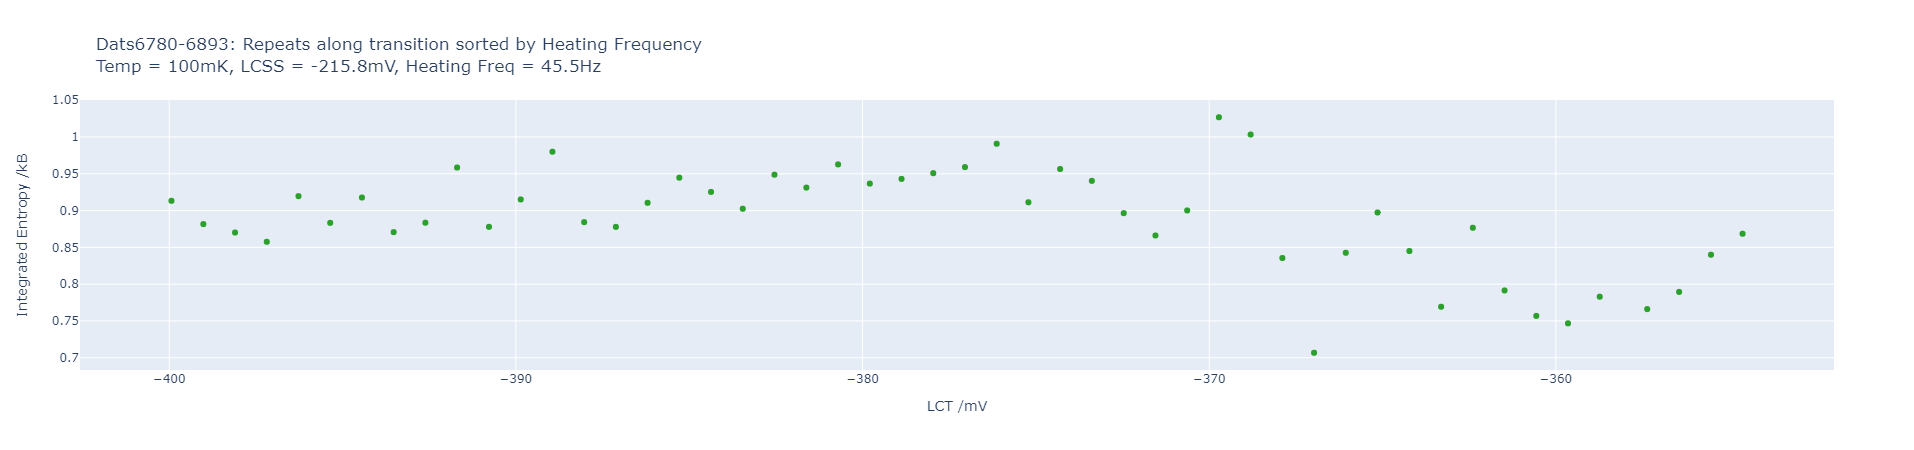

In [28]:
fig = figs[3]
fig2 = copy.copy(fig)

xs, datas = list(), list()
for data in fig.data[1:]:
    xs.append(data.x[:50])
    datas.append(data.y[:50])
xs = np.array(xs)
datas = np.array(datas)

xs = np.mean(xs, axis=0)
datas = np.mean(datas, axis=0)

bin_size=1
                  
fig2.data = [fig2.data[2]]
fig2.data[0].x = xs
fig2.data[0].y = datas
fig2.data[0].error_y = dict()
fig2

In [ ]:
xs = CU.bin_data(xs, bin_size=bin_size)
datas = CU.bin_data(datas, bin_size=bin_size)

xs = np.array(list(xs[0])+list(xs[1]))
datas = np.array(list(datas[0])+list(datas[1]))

px.scatter(x=xs, y=datas)

In [29]:

CU.save_to_mat([xs, datas], ['LCT', 'fit_entropy'], 'Temp/averaged int entropy along transition.mat')

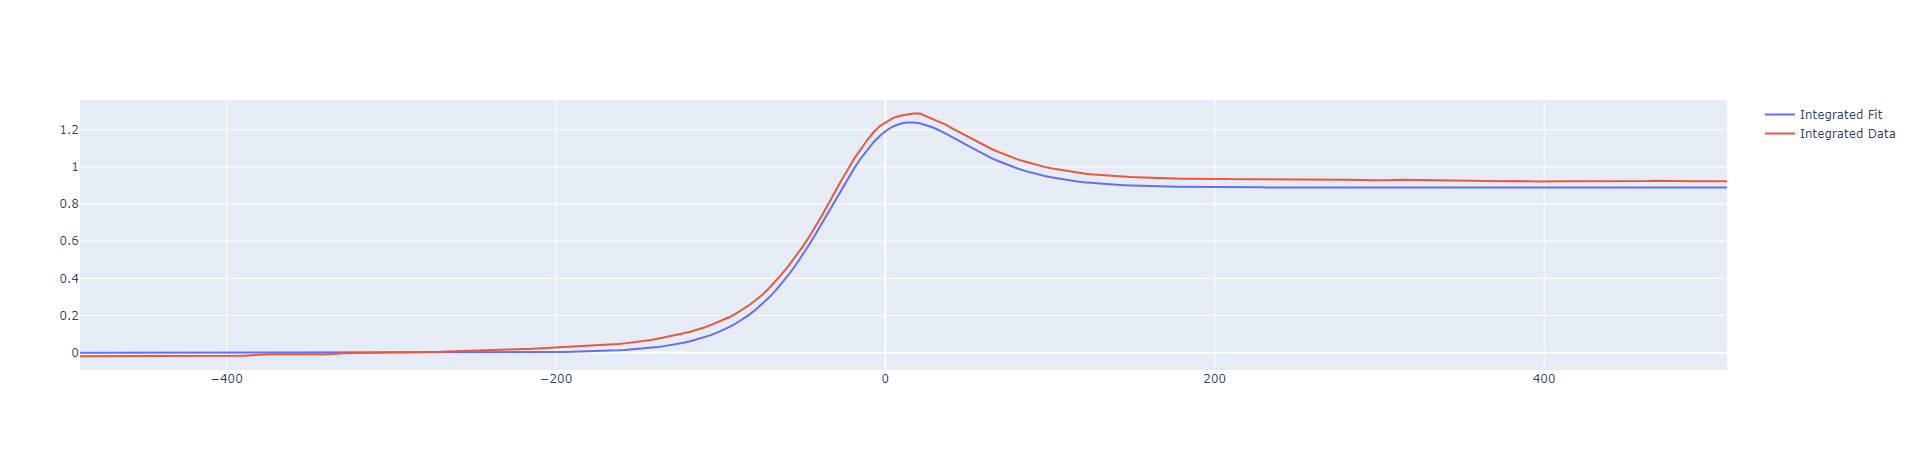

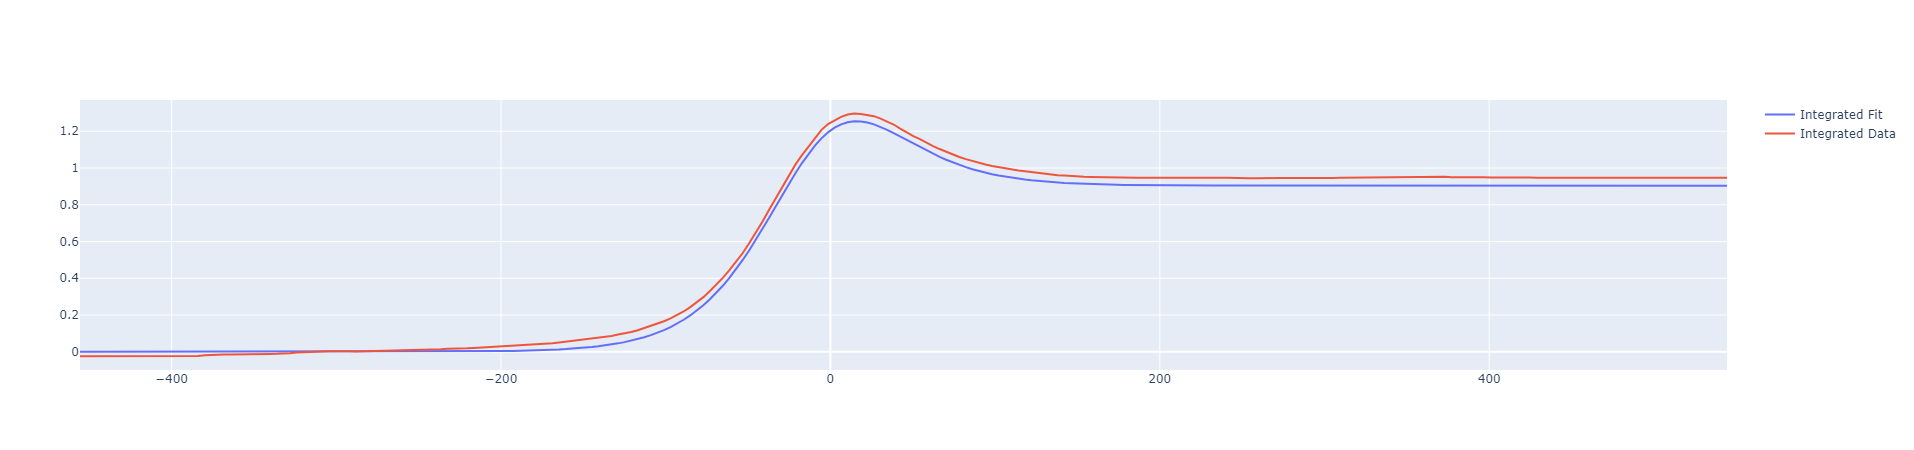

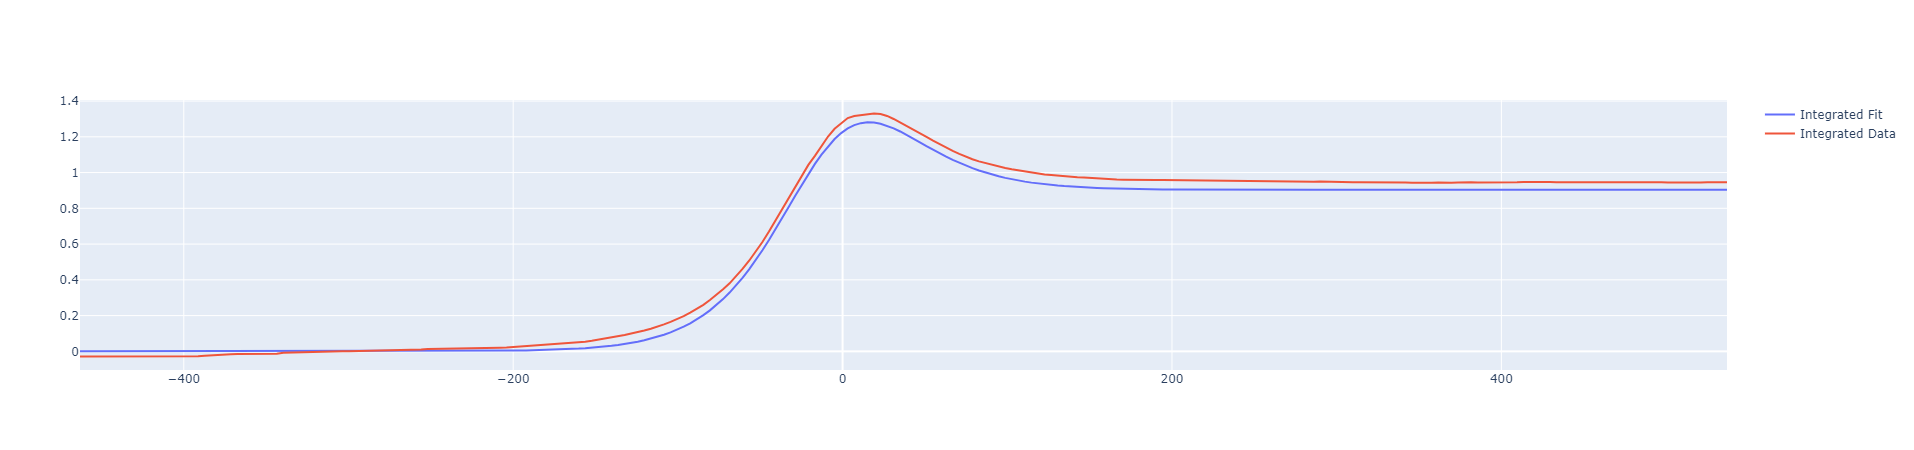

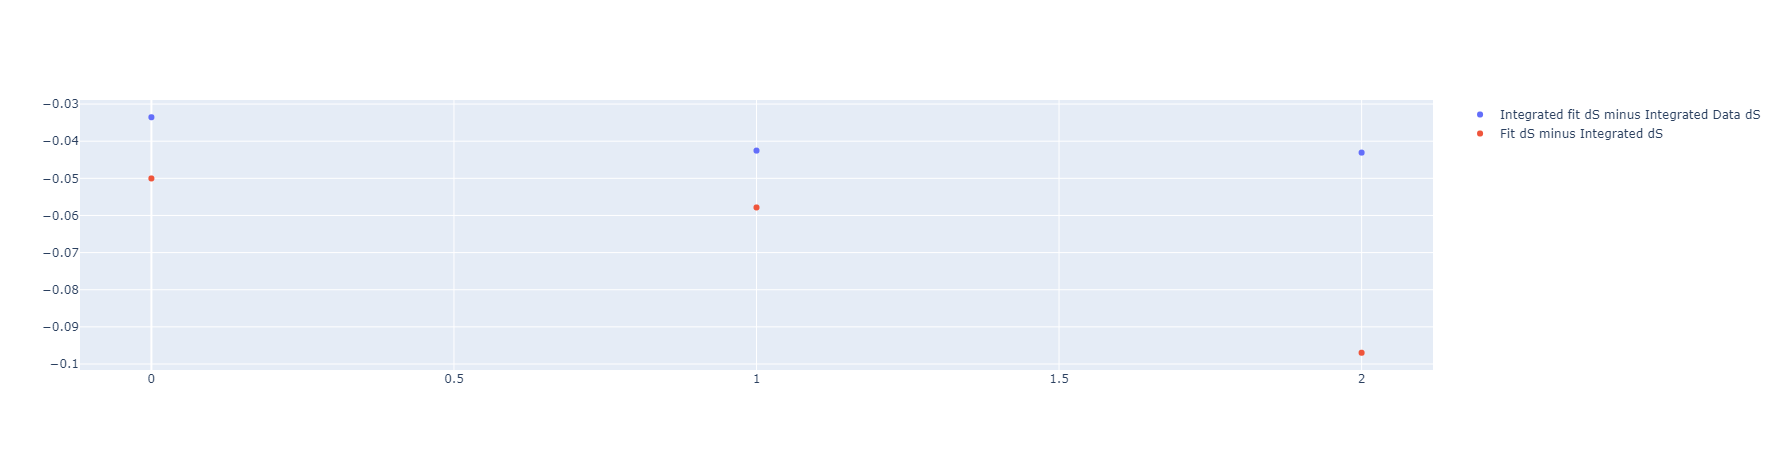

In [27]:
dat = dats[0]

fig = go.Figure()
diffs = list()
fminusint=list()
for dat in dats:
    
    data = EA.get_data(dat)
    values = dat.Other.EA_values

    int_fit = np.nancumsum(values.efit_info.eval_fit(data.x))*values.sf
    diffs.append(int_fit[-1] - data.integrated_data[-1])
    fminusint.append(values.dS - values.int_dS)

    fig_i = go.Figure()
    fig_i.add_trace(go.Scatter(mode='lines', x= data.x, y=int_fit, name='Integrated Fit'))
    fig_i.add_trace(go.Scatter(mode='lines', x= data.x, y=data.integrated_data, name='Integrated Data'))
    fig_i.show()

    
fig.add_trace(go.Scatter(mode='markers', x=list(range(len(dats))), y=diffs, name='Integrated fit dS minus Integrated Data dS'))
fig.add_trace(go.Scatter(mode='markers', x=list(range(len(dats))), y=fminusint, name = 'Fit dS minus Integrated dS'))




## Calculate Average dT/amp from dats

In [170]:
filt_name = 'LCT'
filt_val = lambda dat: dat.Logs.fds['LCT']
filt_func = lambda dat: (filt_val(dat) < -375) and np.isclose(dat.AWG.freq, 12.5, atol=1)

temp_dats = [dat for dat in dats if filt_func(dat)]
temp_dats = CU.order_list(temp_dats, [filt_val(dat) for dat in temp_dats])

get_vals, names, units = list(), list(), list()

get_vals.append(lambda dat: dat.Other.EA_values.dT)
names.append('dT')
units.append('mV')

get_vals.append(lambda dat: dat.Other.EA_values.amp)
names.append('Amp')
units.append('nA')

get_vals.append(lambda dat: dat.Other.EA_values.tc)
names.append('Theta')
units.append('mV')



print(f'For dats{temp_dats[0].datnum}->{temp_dats[-1].datnum} ({filt_name}={filt_val(temp_dats[0]):.0f}->{filt_val(temp_dats[-1]):.0f}mV) avg:')
for get_val, name, unit in zip(get_vals, names, units):
    dts = [get_val(dat) for dat in temp_dats]
    print(f'\t {name} = {np.nanmean(dts):.3f}{unit}, stdev = {np.nanstd(dts):.3f}{unit}')

For dats7316->7384 (LCT=-400->-380mV) avg:
	 dT = 2.716mV, stdev = 0.085mV
	 Amp = 0.954nA, stdev = 0.005nA
	 Theta = 21.186mV, stdev = 0.321mV


In [181]:
# ds = [dd[num] for num in [7073, 7150, 7313, 6796]]
# ds = [dd[num] for num in [7073, 7150, 6796]]
# ds = [dd[7413]]
ds = dats
for dat in progressbar(ds):
    EA.standard_square_process(dat, analysis_params, per_row=True)

N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:536: RuntimeWarning:

Mean of empty slice

D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:578: RuntimeWarning:

Mean of empty slice

D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:600: RuntimeWarning:

Mean of empty slice

 33% (1 of 3) |########                  | Elapsed Time: 0:00:00 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 66% (2 of 3) |#################         | Elapsed Time: 0:00:00 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


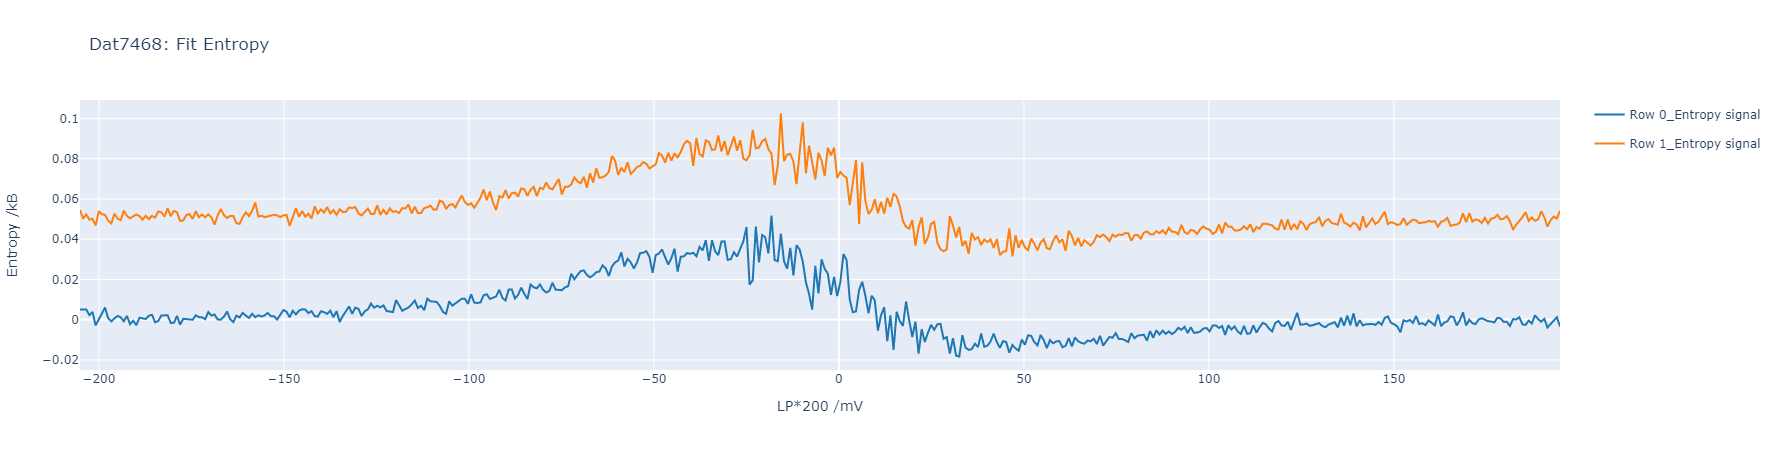

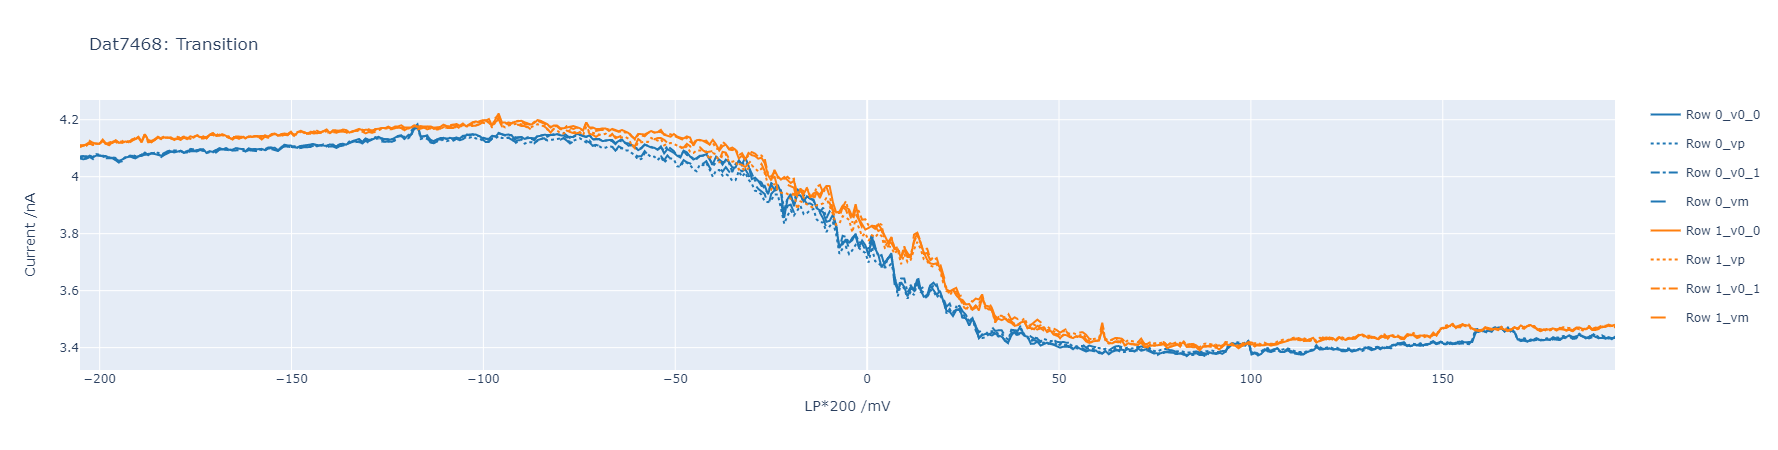

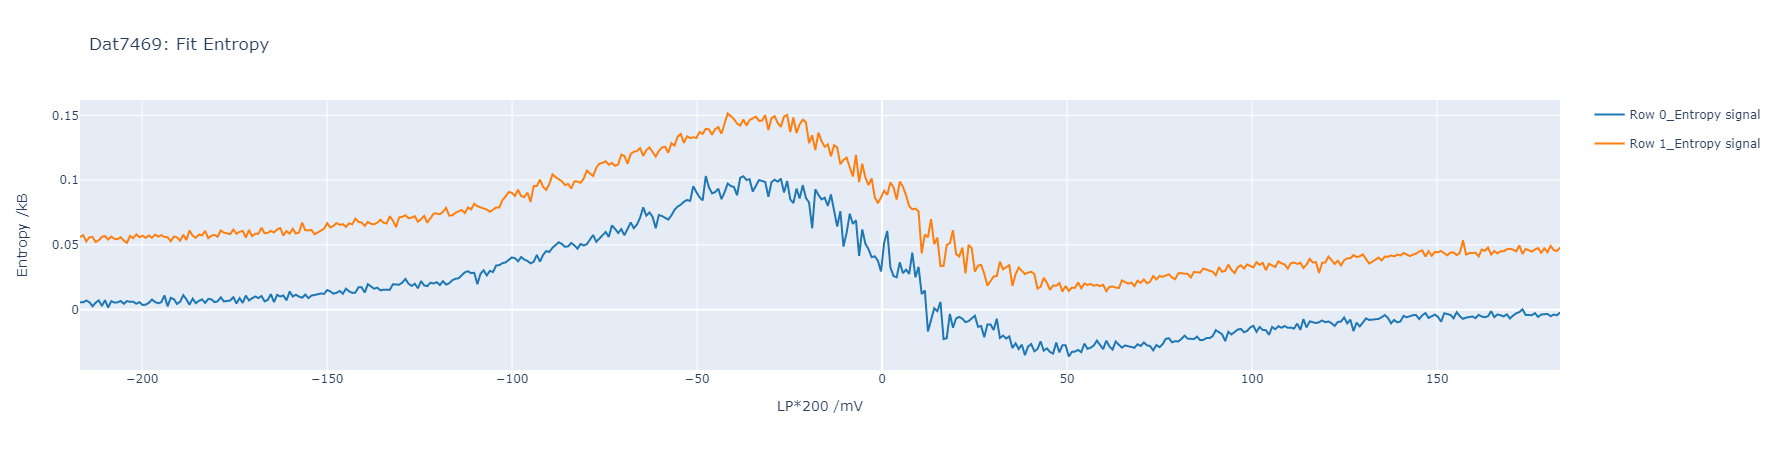

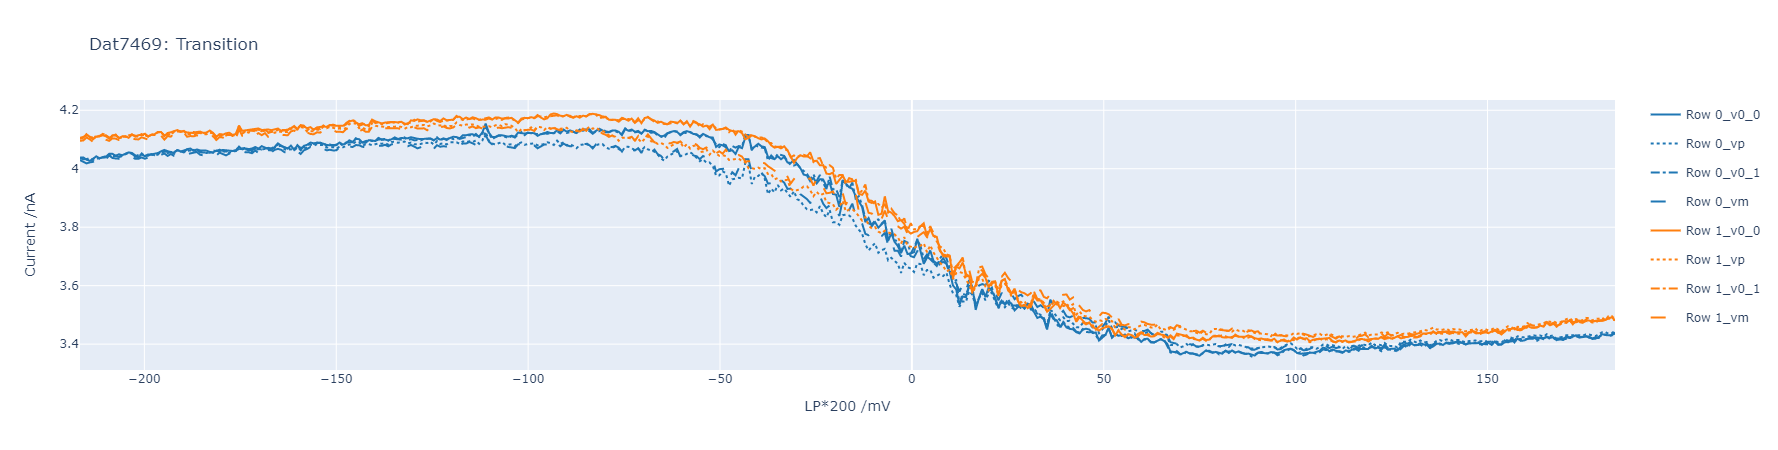

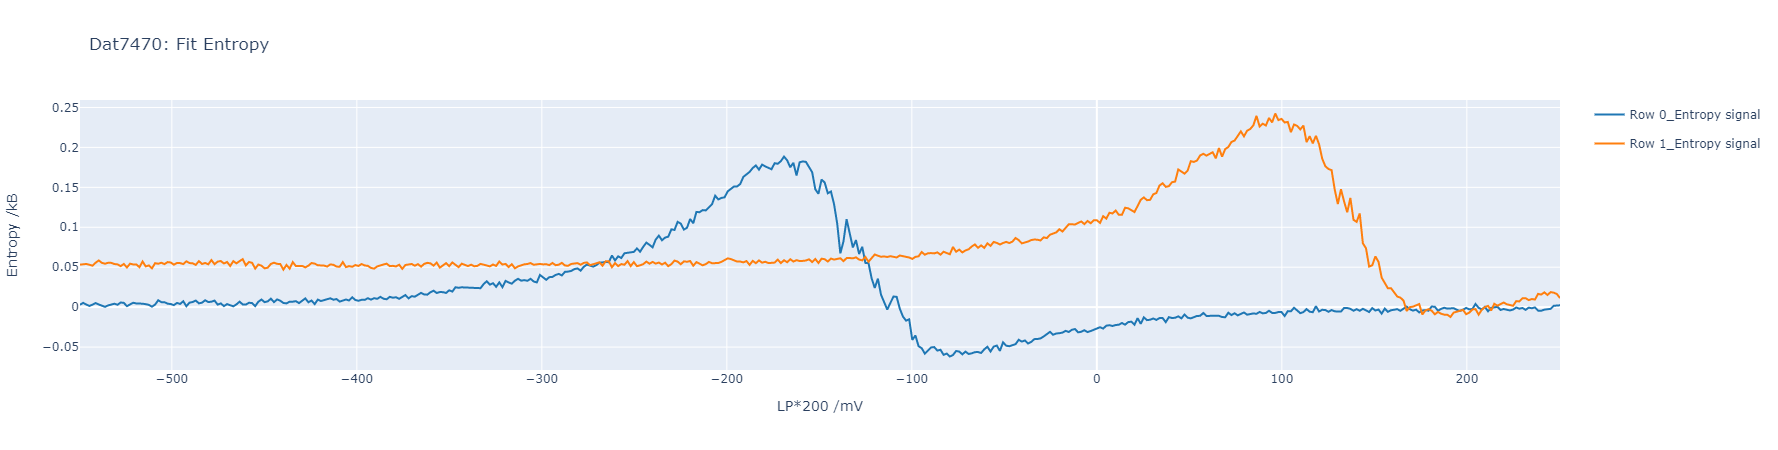

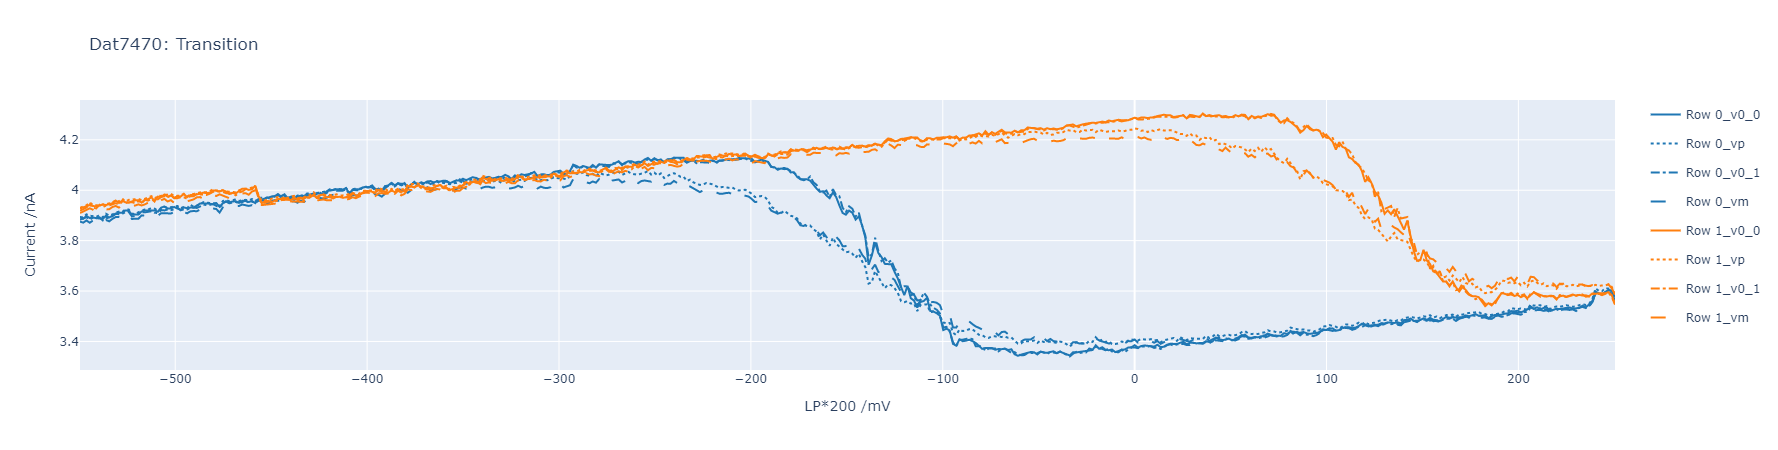

In [207]:
figs = list()
ds = dats
for dat in ds:
    figs.append(EA.Plots.waterfall(dat, 'entropy', single_dat=True, shift_per=0.05))
    figs.append(EA.Plots.waterfall(dat, 'transition', single_dat=True, shift_per=0.05))
for fig in figs:
    fig.show()

In [210]:
for dat in dats:
    values = EA.EA_values.from_dat(dat)
    print(dat.datnum, values.ths)

7468 [22.94603756500201, 24.583749779614198]
7469 [28.017685148615357, 28.86643702207992]
7470 [34.94023769444736, 31.638347657847277]


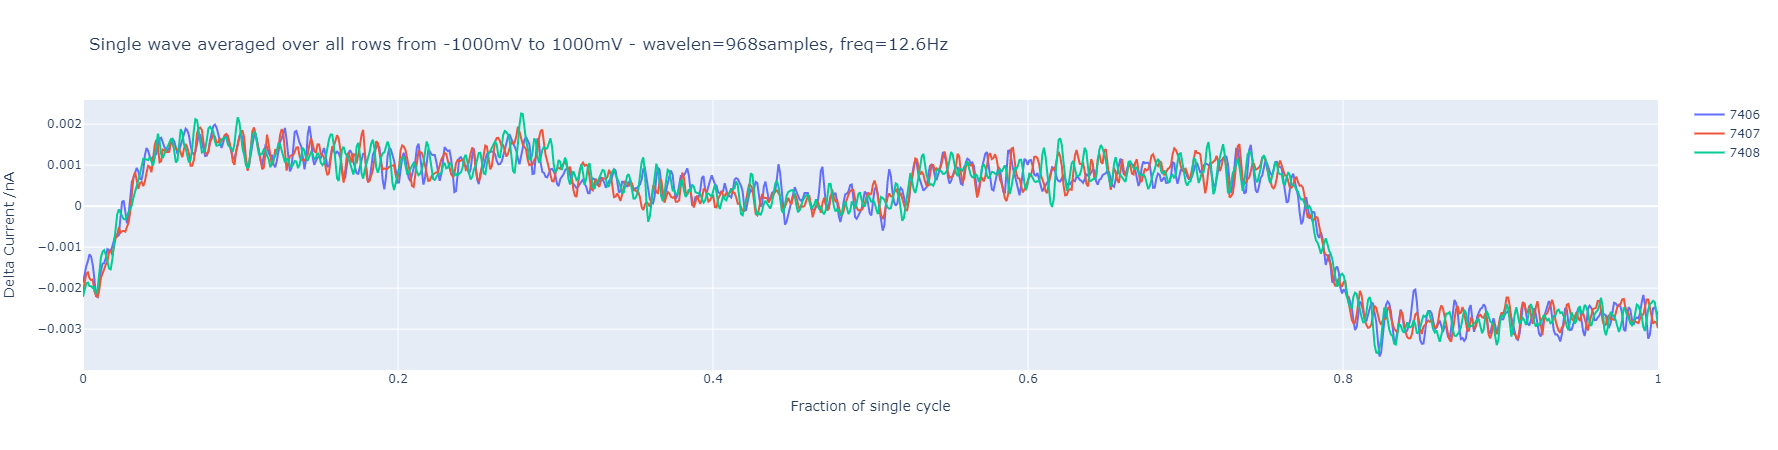

In [30]:

avg_transition_sw(dats, (-1000, 1000))

In [151]:
dats = get_dats((7455, 7457+1), overwrite=True)  # 51Hz 10mV/s to compared to lock-in, then with 2x heating, to compare to older measurements (i.e. I usually use 15% heating now, used to use 30%)


for dat in dats:
    Fixes.fix_magy(dat)

N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 33% (1 of 3) |########                  | Elapsed Time: 0:00:00 ETA:   0:00:01WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 66% (2 of 3) |#################         | Elapsed Time: 0:00:01 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (3 of 3) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [157]:
for dat in dats[-1:]:
    print(dat.datnum, dat.Other.EA_values.dT)

7457 5.916435422737457


In [153]:
for dat in dats:
    if dat.AWG.freq > 50:
        dat.SquareEntropy.Processed.process_params.setpoint_start = int(round(dat.Logs.Fastdac.measure_freq*1e-3))
        dat.SquareEntropy.process()
dat = dats[0]
dat.SquareEntropy.Processed.process_params
dat.Logs.Fastdac.measure_freq

6060.6

In [154]:

analysis_params = EA.EA_params(bin_data=False, num_per_row=500,
                               sub_const=True, sub_const_range=(-350, -250),
                               sub_line=False, sub_line_range=(-4000, -600),
                               int_entropy_range=(250, 350),
                               allowed_amp_range=(0.1,1.601), default_amp=0.954,
                               allowed_dT_range=(0.001, 10.002), default_dT=2.71,
                               CT_fit_range=(-500, 500), CT_fit_func='i_sense', CT_fit_param_edit_kwargs={},
                               fit_param_edit_kwargs=dict(),
                               E_fit_range=(-500, 500), 
                               calculate_uncertainty=True, 
                               batch_uncertainty=1,
                               center_data=True)

In [156]:
for dat in dats:
    EA.standard_square_process(dat, analysis_params)

In [83]:
fig = go.Figure()
EA.Plots.waterfall(dats, 'entropy', single_dat=False)

AttributeError: 'Other' object has no attribute 'EA_values'

In [211]:
# dat = get_dat(7458)
# dat = get_dat(7461)
# dats = get_dats((7458, 7461+1))
# dats = get_dats((7462, 7464+1))
dats = get_dats((7465, 7467+1))
dats.reverse()

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


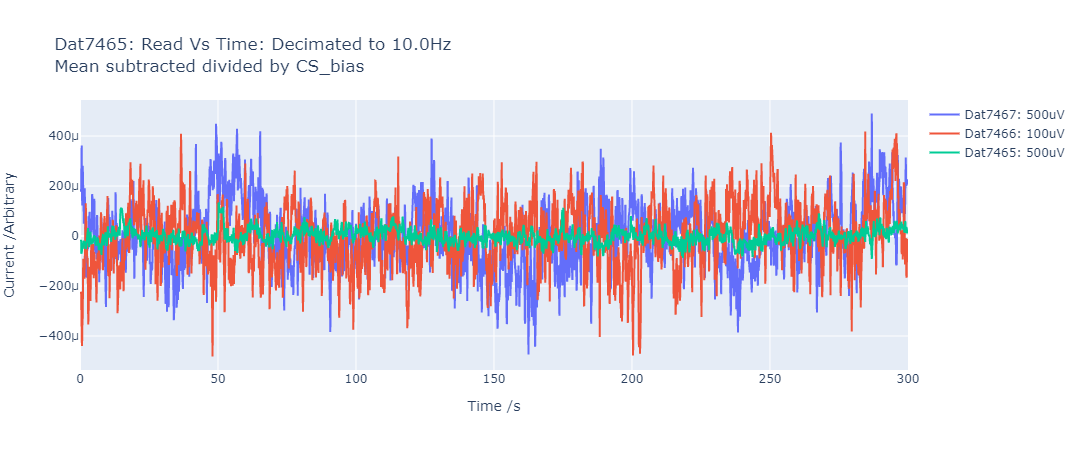

In [133]:
fig = go.Figure()
for dat in dats:
    data = dat.Data.Exp_cscurrent
    x = np.linspace(0, data.shape[-1]/dat.Logs.Fastdac.measure_freq, data.shape[-1])

    data, f = CU.decimate(data, dat.Logs.Fastdac.measure_freq, 10, return_freq=True)
    x = CU.get_matching_x(x, data)
    data = data - np.nanmean(data)
    # f = dat.Logs.Fastdac.measure_freq
    cs_bias = dat.Logs.bds['CSbias/0.0001'] / 10
    data = data/cs_bias
    fig.add_trace(go.Scatter(mode='lines', x=x, y=data, name=f'Dat{dat.datnum}: {cs_bias:.0f}uV'))
    PlU.fig_setup(fig, title=f'Dat{dat.datnum}: Read Vs Time: Decimated to {f:.1f}Hz<br>Mean subtracted divided by CS_bias', x_label = "Time /s", y_label="Current /Arbitrary")

    fig

In [217]:
import plotly.express as px

dat = dats[0]
print(dat.datnum)
f, p = CU.power_spectrum(dat.Data.Exp_cscurrent, dat.Logs.Fastdac.measure_freq)
print(f.shape, p.shape)
lp = np.log(p)
fig = go.Figure()

# fig.add_trace(go.Scatter(mode='lines', x=f[::50], y=p[::50], log_x=True, log_y=True))

fig = px.line(x=f[::50], y=p[::50], log_x=True, log_y=True)
fig.show(renderer='browser')
# for dat in dats:
#     print(dat.datnum, dat.Other.EA_values.g)
#     print(dat.datnum, dat.Logs.AWG.wave_len)

7467
(909151,) (909151,)


In [222]:
val = -2306.8
print(f'Closest DAC step below {val:.2f}mV = {val - val%20000/(2**16):.2f}mV')

Closest DAC step below -2306.80mV = -2307.07mV


In [223]:
## Right side only (missed the S shape first time)
# nlcts = np.arange(-2276.34, -2239.53, 3*20000/(2**16), dtype=np.float64)
# olcts = np.array([-371, -365])/0.163
# olps = np.array([-439, -454.4])

## Left side slighly overlapping with right side
nlcts = np.arange(-2307.07, -2270, 3*20000/(2**16), dtype=np.float64)
olcts = np.array([-376, -365])/0.163
olps = np.array([-426.167, -454.4])

nlps = np.interp(nlcts, olcts, olps)
print(f'Total of {len(nlcts)} positions:\n' \
    f'New LCTs/0.163 = {[round(v, 1) for v in nlcts]}\n' \
     f'New LPs*2 = {[round(v, 1) for v in nlps]}')

Total of 41 positions:
New LCTs/0.163 = [-2307.1, -2306.2, -2305.2, -2304.3, -2303.4, -2302.5, -2301.6, -2300.7, -2299.7, -2298.8, -2297.9, -2297.0, -2296.1, -2295.2, -2294.3, -2293.3, -2292.4, -2291.5, -2290.6, -2289.7, -2288.8, -2287.8, -2286.9, -2286.0, -2285.1, -2284.2, -2283.3, -2282.4, -2281.4, -2280.5, -2279.6, -2278.7, -2277.8, -2276.9, -2275.9, -2275.0, -2274.1, -2273.2, -2272.3, -2271.4, -2270.4]
New LPs*2 = [-426.2, -426.4, -426.8, -427.2, -427.6, -427.9, -428.3, -428.7, -429.1, -429.5, -429.9, -430.2, -430.6, -431.0, -431.4, -431.8, -432.2, -432.5, -432.9, -433.3, -433.7, -434.1, -434.5, -434.8, -435.2, -435.6, -436.0, -436.4, -436.8, -437.1, -437.5, -437.9, -438.3, -438.7, -439.1, -439.4, -439.8, -440.2, -440.6, -441.0, -441.4]
